<a href="https://colab.research.google.com/github/hossein20s/Average_Blood_Pressure_estimation/blob/master/Ramtin_code_via_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import datetime as dt

class Timer():

	def __init__(self):
		self.start_dt = None

	def start(self):
		self.start_dt = dt.datetime.now()

	def stop(self):
		end_dt = dt.datetime.now()
		print('Time taken: %s' % (end_dt - self.start_dt))

In [0]:
import keras

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


Using TensorFlow backend.


In [0]:
!pip install gcsfs

import pandas as pd

case_id = '01'
data = pd.read_csv('http://storage.googleapis.com/medicalblockchain_dev/data/UniversityQueenslandVitalSignals/case%s/uq_vsd_case%s_trenddata.csv'%(case_id, case_id),\
                               error_bad_lines=False, warn_bad_lines=False, index_col=False);
data = data[["RelativeTimeMilliseconds", "NBP (Mean)", "Minute Volume"]].dropna()
data = (data - data.mean())/(data.max() - data.min())


DATA_FILE = 'case1_trends_3column.csv'

data.to_csv(DATA_FILE)


In [0]:
import numpy as np
import pandas as pd

class data_reader():
    def __init__(self, filename, l=10, batchsize=32, random=True):
        # process the data into a matrix, and return the lenght
        print("Warning: Data passed should be normalized!")
        self.frac = 0.65
        self.random = random
        df = pd.read_csv(filename)
        self.process(df, l)
        self.batchsize = batchsize

        self.pointer = 0
        self.epoch = 0
    def process(self, df, l):
        # Generate the data matrix
        print(df.head(3))
        df = df[["NBP (Mean)", "Minute Volume"]].dropna().as_matrix()
        length = df.shape[0]
        data = np.zeros((length-l, l))
        label = np.zeros((length-l, 1))
        for counter in range(length-l):
            data[counter, :] = df[counter: counter+l, 1]
            label[counter, :] = df[counter+l, 0]
        # Random shuffle
        length = data.shape[0]
        idx = np.random.choice(length, length, replace=False)
        if not self.random:
            idx = np.arange(length)
        self.val_idx = idx[int(self.frac*length):]

        shuf_data = data[idx, :]
        shuf_label = label[idx, :]
        self.data =data
        self.label = label

        self.train_data = shuf_data[:int(self.frac*length), :]
        self.train_label = shuf_label[:int(self.frac*length), :]
        self.train_size = int(self.frac*length)

        self.val_data = shuf_data[int(self.frac*length):, :]
        self.val_label = shuf_label[int(self.frac*length):, :]
        self.val_size = int((1-self.frac)*length)

        return None

    def get_next_train_batch(self):
        # getting the next train batch
        if self.pointer + self.batchsize >= self.train_size:
            end = self.train_size
            start = self.pointer
            self.pointer = 0
            self.epoch += 1
        else:
            end = self.pointer + self.batchsize
            start = self.pointer
            self.pointer += self.batchsize
        X = np.expand_dims(self.train_data[start:end, :], axis=-1)
        Y = self.train_label[start:end, :]
        return X, Y

    def get_val(self):
        X = np.expand_dims(self.val_data, axis=-1)

        return X, self.val_label[:]

    def get_whole(self):
        # get whole, for validation set
        X = np.expand_dims(self.data[:, :], axis=-1)
        Y = self.label[:, :]
        return X, Y

    def reset(self):
        self.pointer = 0
        self.epoch = 0

    def get_epoch(self):
        # return the current epoch
        return self.epoch

In [0]:

import json
!wget "bit.ly/ramtinconfig" -O config.ramtin.json
CONFIG_JSON_FILE = 'config.ramtin.json'
import os
configs = json.load(open(CONFIG_JSON_FILE, 'r'))

'''
data = DataLoader(
	os.path.join('data', configs['data']['filename']),
	configs['data']['train_test_split'],
	configs['data']['columns']
)
'''
array_size = configs['training']['feature_size']
reader = data_reader(
	os.path.join( configs['data']['filename']),
	l=array_size,
	batchsize=configs['training']['batch_size']
)


--2019-06-11 07:05:07--  http://bit.ly/ramtinconfig
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/hossein20s/Average_Blood_Pressure_estimation/master/config.ramtin.json [following]
--2019-06-11 07:05:08--  https://raw.githubusercontent.com/hossein20s/Average_Blood_Pressure_estimation/master/config.ramtin.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1153 (1.1K) [text/plain]
Saving to: ‘config.ramtin.json’

config.ramtin.json  100%[===================>]   1.13K  --.-KB/s    in 0s      

2019-06-11 07:05:08 (152 MB/s) - ‘config.ramtin.json’ saved [1153/1153]

   Unnamed: 0  Relativ

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
import os
import math
import numpy as np
import datetime as dt
from numpy import newaxis
from keras.layers import Dense, Activation, Dropout, LSTM
from keras import Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import TimeDistributed
from keras.layers import RepeatVector, Conv1D, MaxPool1D, Flatten

class TheModel():
  """A class for an building and inferencing an lstm model"""

  def __init__(self):
    self.model = Sequential()

  def load_model(self, filepath):
    print('[Model] Loading model from file %s' % filepath)
    self.model = load_model(filepath)

  def build_model(self, configs):
    timer = Timer()
    timer.start()
    timer.start()
    
    input_shape = None
    has_input_shape = False
    is_first_layer = True



    for layer in configs['model']['layers']:
      neurons = layer['neurons'] if 'neurons' in layer else None
      rate = layer['rate'] if 'rate' in layer else None
      activation = layer['activation'] if 'activation' in layer else None
      return_seq = layer['return_seq'] if 'return_seq' in layer else None
      input_timesteps = layer['input_timesteps'] if 'input_timesteps' in layer else None
      input_dim = layer['input_dim'] if 'input_dim' in layer else None
      kernel_size = layer['kernel_size'] if 'kernel_size' in layer else None
      filters = layer['filters'] if 'filters' in layer else None
      strides = layer['strides'] if 'strides' in layer else 1
      print(kernel_size)
      if 'input_shape' in layer:
        input_shape = layer['input_shape']
        has_input_shape = true

      if layer['type'] == 'dense':
        if(is_first_layer):
          self.model.add(Dense(neurons, activation=activation, input_shape=input_shape))
          is_first_layer = False
        else:
          self.model.add(Dense(neurons, activation=activation))
      if layer['type'] == 'lstm' or layer['type'] == 'conv1D':
        input_shape=(input_timesteps, input_dim)
        has_input_shape = True
        if(layer['type'] == 'lstm'):
          if is_first_layer:
            self.model.add(LSTM(neurons, input_shape=input_shape, return_sequences=return_seq))
            is_first_layer = False
          else:
            self.model.add(LSTM(neurons, return_sequences=return_seq))
        if(layer['type'] == 'conv1D'):
          if is_first_layer:
            self.model.add(Conv1D(filters, kernel_size, strides=strides, activation=activation, input_shape=input_shape))
            is_first_layer = False
          else:
            self.model.add(Conv1D(filters, kernel_size, strides=strides, activation=activation))
      if layer['type'] == 'dropout':
          self.model.add(Dropout(rate))
      if layer['type'] == 'flatten':
          self.model.add(Flatten())
      if layer['type'] == 'maxpool1D':
          self.model.add(MaxPool1D(rate))
      if layer['type'] == 'repeat_vector':
        self.model.add(RepeatVector(input_timesteps))
      if layer['type'] == 'time_distributed_dense':
        self.model.add(TimeDistributed(Dense(neurons, activation=activation)))
      if layer['type'] == 'attention_decoder':
        self.model.add(AttentionDecoder(neurons, input_dim))
      if layer['type'] == 'attention':
        self.model.add(Attention())

    print(configs['model']['metrics'])
    self.model.compile(loss=configs['model']['loss'], 
                       optimizer=configs['model']['optimizer'],
                      metrics=configs['model']['metrics'])
    print('[Model] Model Compiled')
    print('input_shape: ',input_shape)
    if has_input_shape:
      self.model.summary()
    timer.stop()

  def fit(self, x, y, epochs, batch_size, validation_split, save_dir):
    timer = Timer()
    timer.start()
    print('[Model] Training Started')
    print('[Model] %s epochs, %s batch size' % (epochs, batch_size))

    save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))

    callbacks = [
        PrintDot()
    #            EarlyStopping(monitor='val_loss', patience=2),
    #            ModelCheckpoint(filepath=save_fname, monitor='val_loss', save_best_only=True)
    ]
    history = self.model.fit(
      x,
      y,
      epochs=epochs,
      batch_size=batch_size,
      validation_split = validation_split, 
      verbose=0,
      callbacks=callbacks
    )
    self.model.save(save_fname)

    print('[Model] Training Completed. Model saved as %s' % save_fname)
    timer.stop()
    return history

  def fit_generator(self, data_gen, epochs, batch_size, steps_per_epoch, save_dir):
    timer = Timer()
    timer.start()
    print('[Model] Training Started')
    print('[Model] %s epochs, %s batch size, %s batches per epoch' % (epochs, batch_size, steps_per_epoch))

    save_fname = os.path.join(save_dir, '%s-e%s.h5' % (dt.datetime.now().strftime('%d%m%Y-%H%M%S'), str(epochs)))
    callbacks = [
      ModelCheckpoint(filepath=save_fname, monitor='loss', save_best_only=True)
    ]
    self.model.fit_generator(
      data_gen,
      steps_per_epoch=steps_per_epoch,
      epochs=epochs,
      callbacks=callbacks,
      workers=1
    )

    print('[Model] Training Completed. Model saved as %s' % save_fname)
    timer.stop()

  def predict_point_by_point(self, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    print('[Model] Predicting Point-by-Point...')
    predicted = self.model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

  def predict_sequences_multiple(self, data, window_size, prediction_len):
    #Predict sequence of 50 steps before shifting prediction run forward by 50 steps
    print('[Model] Predicting Sequences Multiple...')
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
      curr_frame = data[i*prediction_len]
      predicted = []
      for j in range(prediction_len):
        predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
      prediction_seqs.append(predicted)
    return prediction_seqs

  def predict_sequence_full(self, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    print('[Model] Predicting Sequences Full...')
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
      predicted.append(self.model.predict(curr_frame[newaxis,:,:])[0,0])
      curr_frame = curr_frame[1:]
      curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
    return predicted



In [0]:

import json

theModel = TheModel()
print(configs)
theModel.build_model(configs)

max_epoch = configs['training']['epochs']

epoch = reader.get_epoch()

x = np.expand_dims(reader.train_data, axis=-1)
y = reader.train_label
history = theModel.fit(
  x,
  y,
  epochs = max_epoch,
  batch_size = configs['training']['batch_size'],
  validation_split = configs['training']['validation_split'],
  save_dir = configs['model']['save_dir']
)

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


{'data': {'columns': ['RelativeTimeMilliseconds, NBP (Mean), Minute Volume'], 'filename': 'case1_trends_3column.csv', 'n_features': 1, 'normalise': True, 'sequence_length': 64, 'train_test_split': 0.85}, 'model': {'layers': [{'filters': 10, 'input_dim': 1, 'input_timesteps': 80, 'kernel_size': 20, 'strides': 5, 'type': 'conv1D'}, {'filters': 20, 'kernel_size': 5, 'type': 'conv1D'}, {'filters': 40, 'kernel_size': 5, 'type': 'conv1D'}, {'type': 'flatten'}, {'activation': 'linear', 'neurons': 1, 'type': 'dense'}], 'loss': 'mse', 'metrics': ['mse', 'acc'], 'optimizer': 'adam', 'save_dir': '/tmp'}, 'training': {'batch_size': 64, 'epochs': 500, 'feature_size': 80, 'validation_split': 0.35}}
20
5
5
None
None
['mse', 'acc']
[Model] Model Compiled
input_shape:  (None, None)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 13, 10)            210       
__________________________

,val_loss,val_mean_squared_error,val_acc,loss,mean_squared_error,acc,epoch
495,0.044678,0.044678,0.0,0.040691,0.040691,0.0,495
496,0.044394,0.044394,0.0,0.040605,0.040605,0.0,496
497,0.044461,0.044461,0.0,0.040825,0.040825,0.0,497
498,0.044554,0.044554,0.0,0.040794,0.040794,0.0,498
499,0.043957,0.043957,0.0,0.040716,0.040716,0.0,499


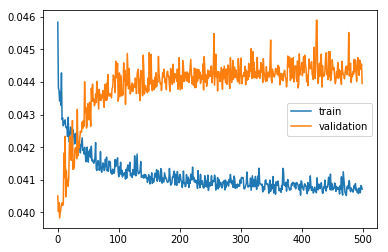

In [24]:
import matplotlib.pyplot as plt

plt.plot(np.arange(max_epoch), history.history['loss'], label='train')
plt.plot(np.arange(max_epoch), history.history['val_loss'], label='validation')
plt.legend()
